In [65]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cleverhans
%matplotlib inline
from cleverhans.model import Model
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils_mnist import data_mnist
import math

import PIL
import os
import glob
from skimage import io


In [66]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
%autoreload 2

In [68]:
import sgld_tf

In [69]:
X_train, Y_train, X_test, Y_test = data_mnist(train_start=0,
                                                  train_end=60000,
                                                  test_start=0,
                                                  test_end=10000)

Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [70]:
root_dir = '../data/notMNIST_small/'
fl = glob.glob(os.path.join(root_dir, '**', '*.png'))

In [71]:
start, size = 30000, 10000
notmnist = []
for f in fl:
    try:
        notmnist.append(np.array(io.imread(f))/255.0)
    except:
        pass
    
notmnist = np.array(notmnist)

In [72]:
notmnist = notmnist.reshape((-1, 28, 28, 1))

In [73]:
notmnist.shape

(18724, 28, 28, 1)

In [74]:
to_run = {'optimizers': ['sgd', 'sgd', 'sgld', 'psgld', 'ksgld'],
         'names': ['sgd', 'sgda', 'sgld', 'psgld', 'ksgld'],
         'bayes_n': [1, 118, 118, 118, 118],
         'lr': [0.01, 0.01, 0.02, 0.02, 0.02, 0.02]}
batch_size = 512
n_epochs = 10
directory = '/tmp/tf/sgd_mine/'

In [75]:
results = []
for i, name in enumerate(to_run['names']):
    print('training ', name)
    tf.reset_default_graph()
    tf.logging.set_verbosity(tf.logging.ERROR)
    x, y, preds, logits, loss, train_step, saver, sess, adv_preds = sgld_tf.make_graph(to_run['optimizers'][i],
                                                                                      to_run['lr'][i])
    sgld_tf.train(n_epochs, sess, batch_size, X_train, Y_train, X_test, Y_test, x,
                 y, preds, train_step, loss, directory)
    model_files = sgld_tf.ordered_chkpoints_from_dir(directory)
    model_files = model_files[-to_run['bayes_n'][i]:]
    print('inference ', name)
    distrib = sgld_tf.bayes_uncertainty(model_files, directory, sess, batch_size, notmnist[-10000:], Y_test,
                            x, y, preds)
    results.append(np.max(distrib, axis=1))


training  sgd
epoch:  0
eval acc 0.75
epoch:  1
eval acc 0.85
epoch:  2
eval acc 0.8926
epoch:  3
eval acc 0.9099
epoch:  4
eval acc 0.9213
epoch:  5
eval acc 0.9293
epoch:  6
eval acc 0.9348
epoch:  7
eval acc 0.9396
epoch:  8
eval acc 0.9433
epoch:  9
eval acc 0.9468
inference  sgd
training  sgda
epoch:  0
eval acc 0.7098
epoch:  1
eval acc 0.8572
epoch:  2
eval acc 0.8987
epoch:  3
eval acc 0.916
epoch:  4
eval acc 0.9248
epoch:  5
eval acc 0.9314
epoch:  6
eval acc 0.9369
epoch:  7
eval acc 0.9414
epoch:  8
eval acc 0.9454
epoch:  9
eval acc 0.948
inference  sgda
training  sgld
epoch:  0
eval acc 0.7241
epoch:  1
eval acc 0.8193
epoch:  2
eval acc 0.8884
epoch:  3
eval acc 0.9089
epoch:  4
eval acc 0.9205
epoch:  5
eval acc 0.9269
epoch:  6
eval acc 0.9313
epoch:  7
eval acc 0.9373
epoch:  8
eval acc 0.9397
epoch:  9
eval acc 0.9421
inference  sgld
training  psgld
Tensor("pSGLD/update_conv2d/kernel/ExponentialDecay:0", shape=(), dtype=float32)
Tensor("pSGLD/update_conv2d/bias/Expon

NotFoundError: Key conv2d/bias/pSGLD not found in checkpoint
	 [[Node: save_2/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT32], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_2/Const_0_0, save_2/RestoreV2/tensor_names, save_2/RestoreV2/shape_and_slices)]]

Caused by op 'save_2/RestoreV2', defined at:
  File "/home/henripal/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/henripal/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-75-edcbed9a2181>", line 14, in <module>
    x, y, preds)
  File "/home/henripal/projects/sgld_tf/sgld_tf/adversarial.py", line 96, in bayes_uncertainty
    saver = tf.train.Saver()
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1311, in __init__
    self.build()
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1320, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1357, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 809, in _build_internal
    restore_sequentially, reshape)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 448, in _AddRestoreOps
    restore_sequentially)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 860, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1458, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/henripal/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key conv2d/bias/pSGLD not found in checkpoint
	 [[Node: save_2/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT32], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_2/Const_0_0, save_2/RestoreV2/tensor_names, save_2/RestoreV2/shape_and_slices)]]


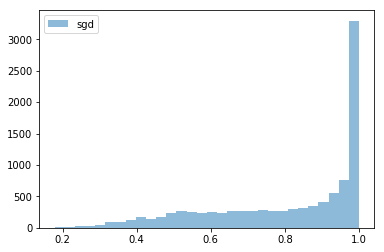

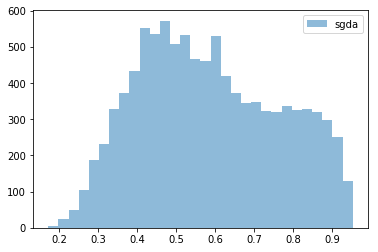

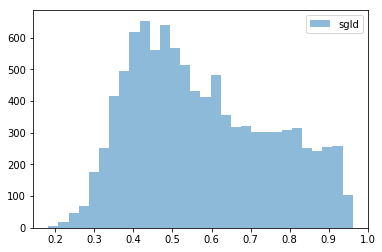

In [76]:
for i, d in enumerate(results):
    plt.hist(d, alpha=.5, bins=30, label=to_run['names'][i]);
    plt.legend()
    plt.show()
    

In [ ]:
plt.hist(sgld_maxd, alpha=.5);
plt.hist(sgd_maxd, alpha=.5);

In [ ]:
sgld_maxd = maxd

In [ ]:
sgd_maxd = maxd